In [13]:
import os
import sys
import time
import datetime

import pandas as pd
import numpy as np
import scipy as sp

# Ensure we are using development version of knockpy
file_directory = os.path.dirname(os.path.abspath(''))
parent_directory = os.path.split(file_directory)[0]
knockoff_directory = parent_directory + '/adaptive/knockpy/'
sys.stdout.write(f'Knockoff dir is {knockoff_directory}\n')
sys.path.insert(0, os.path.abspath(knockoff_directory))

# Use knockpy >= 1.0.0
import knockpy
print(f"Using knockpy version {knockpy.__version__}; please use version == 1.0.1")

Knockoff dir is /home/asher/Documents/Research/Knockoff/adaptive/knockpy/
Using knockpy version 1.0.0; please use version >= 1.0.0


## Figures 2 and 11

#### Helper Functions for Figures 2 and 11

In [2]:
import warnings
warnings.filterwarnings("ignore")
import plotnine
from plotnine import *
warnings.simplefilter("always")

In [3]:
def plot_W_path(W, beta):
    """
    Given feature-statistics W and a vector of coefficients beta,
    creates a dataframe used for plotting.
    """
    p = W.shape[0]
    inds = np.argsort(-1*np.abs(W), axis=0)
    sortW = np.take_along_axis(W, inds, axis=0)
    sortbeta = np.take_along_axis(beta, inds, axis=0)
    df = pd.DataFrame()
    df['W'] = sortW
    df['rank'] = np.arange(p)
    df['beta'] = sortbeta
    df['Null'] = df['beta'] == 0
    return df

def fetch_W_df(**sample_kwargs):
    """
    Creates the dataframe used to create one panel of Figure 11.
    The data-sampling process is defined by sample_kwargs.
    """
    
    np.random.seed(1234) # Reproducability
    dgprocess = knockpy.dgp.DGP()
    X, y, beta, Q, V = dgprocess.sample_data(
        **sample_kwargs
    )
    
    # MVR knockoff filter
    kfmvr = knockpy.knockoff_filter.KnockoffFilter(
        ksampler='gaussian', fstat='lcd'
    )
    kfmvr.forward(
        X=X,
        Sigma=V, 
        y=y,
        knockoff_kwargs={'method':'mvr'}
    )

    kfsdp = knockpy.knockoff_filter.KnockoffFilter(
        ksampler='gaussian', fstat='lcd'
    )
    kfsdp.forward(
        X=X,
        Sigma=V, 
        y=y,
        knockoff_kwargs={'method':'sdp'}
    )
    
    # Construct dataframe for eventual plotting
    df_mvr = plot_W_path(kfmvr.W, beta)
    df_mvr['S_method'] = "MVR"
    df_sdp = plot_W_path(kfsdp.W, beta)
    df_sdp['S_method'] = "SDP"
    df = pd.concat([df_mvr, df_sdp], sort=False)
    df['sign'] = (2*(df['W'] > 0) - 1).astype(str)
    
    # Data dependent threshhold dataframe
    Tmvr = kfmvr.threshold
    posmvr = np.argmax(np.abs(df_mvr['W'].values) < Tmvr) - 1
    Tsdp = kfsdp.threshold
    possdp = np.argmax(np.abs(df_sdp['W'].values) < Tsdp) - 1
    Tdf = pd.DataFrame()
    Tdf['T'] = [posmvr, possdp]
    Tdf['S_method'] = ['MVR','SDP']
    Tdf['sign'] = 'data-dependent-threshhold'
    
    return df, Tdf

### Plot 2

In [4]:
Wequi, Tequi = fetch_W_df(n=190, p=100, sparsity=0.5, method='blockequi', rho=0.6, gamma=1)
Wequi['method'] = 'Equicorr.'
Tequi['method'] = 'Equicorr.'

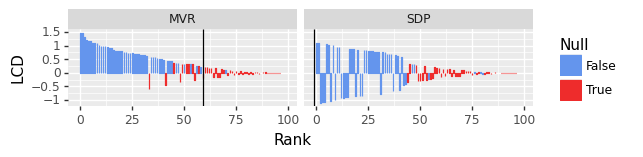

<ggplot: (8749872035227)>


In [5]:
g = (ggplot(
    Wequi, aes(x='rank', y='W', color='Null', fill='Null')
) + geom_col(width=0.3)
  + facet_grid('~S_method')
  + labs(x='Rank', y='LCD')#, title='LCD Statistics for MVR and SDP, Equicorrelated Gaussian Designs')
  + geom_vline(
      data = Tequi,
      mapping=aes(xintercept='T', linetype='sign'),
  )
  + guides(
      linetype = None,#guide_legend(title=''),
      fill = guide_legend(title='Null'),
      color = guide_legend(title='Null'),
  )
  + scale_color_manual(values=('cornflowerblue', '#ee2c2c'))
  + scale_fill_manual(values=('cornflowerblue', '#ee2c2c'))
  + theme(figure_size=(6,1))
)
print(g)

#### Plot 11

In [6]:
# Block-equicorrelated panel
Wbequi, Tbequi = fetch_W_df(n=190, p=100, sparsity=0.5, method='blockequi', rho=0.6, gamma=0)
Wbequi['method'] = 'Block Equi.'
Tbequi['method'] = 'Block Equi.'

# ER (Cov) panel
Wver, Tver = fetch_W_df(n=190, p=100, sparsity=0.5, method='ver', delta=0.2)
Wver['method'] = 'ER (Cov)'
Tver['method'] = 'ER (Cov)'

# ER (precision) panel
Wqer, Tqer = fetch_W_df(n=190, p=100, sparsity=0.5, method='qer', delta=0.2)
Wqer['method'] = 'ER (Prec)'
Tqer['method'] = 'ER (Prec)'

# AR1 panel
War1, Tar1 = fetch_W_df(n=190, p=100, sparsity=0.5, method='ar1', a=3)
War1['method'] = 'AR1'
Tar1['method'] = 'AR1'

# AR1 (corr) panel
War1c, Tar1c = fetch_W_df(n=190, p=100, sparsity=0.5, method='ar1', corr_signals=True, a=3)
War1c['method'] = 'AR1 (Corr)'
Tar1c['method'] = 'AR1 (Corr)'
Wdf = pd.concat([Wequi, Wver, Wqer, War1, War1c, Wbequi], sort=True)
Tdf = pd.concat([Tequi, Tver, Tqer, Tar1, Tar1c, Tbequi], sort=True)

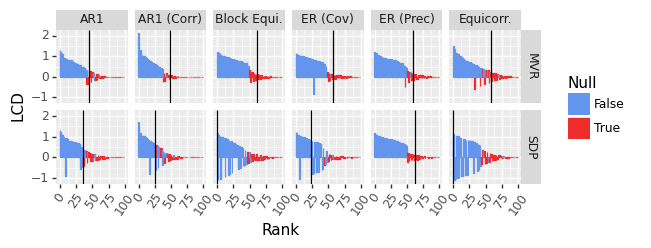

<ggplot: (-9223363287148190804)>


In [7]:
g = (ggplot(
    Wdf, aes(x='rank', y='W', color='Null', fill='Null')
) + geom_col()
  + facet_grid('S_method~method')
  + labs(x='Rank', y='LCD')
  + geom_vline(
      data = Tdf,
      mapping=aes(xintercept='T', linetype='sign'),
  )
  + guides(
      linetype = None,#guide_legend(title=''),
      fill = guide_legend(title='Null'),
      color = guide_legend(title='Null'),
  )
  + scale_color_manual(values=('cornflowerblue', '#ee2c2c'))
  + scale_fill_manual(values=('cornflowerblue', '#ee2c2c'))
  + theme(figure_size=(6,2),  axis_text_x=element_text(rotation=55))
)
print(g)

## Figure 12

In [8]:
warnings.filterwarnings('ignore')
rhos = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
ps = 5 + 50*np.arange(10)
output = pd.DataFrame(index = ps, columns = rhos)
for rho in rhos:
    print(f"At rho={rho}")
    for p in ps:
        # Generate equicorrelated Sigma and SMVR/SMII solutions
        Sigma = rho*np.ones((p,p)) + (1-rho)*np.eye(p)
        SMVR = knockpy.mrc.solve_mvr(Sigma)
        SMMI = knockpy.mrc.solve_mmi(Sigma)
        # Add the |SMVR - SMMI|_{\infty} to the output
        maxdiff = np.max(np.abs(np.diag(SMVR - SMMI)))
        output.loc[p, rho] = maxdiff

At rho=0.1
At rho=0.3
At rho=0.5
At rho=0.7
At rho=0.9


In [9]:
df = output.reset_index()
df = df.rename(columns={'index':'p'})
df = pd.melt(df, id_vars='p', var_name='rho', value_name='value')
df['value'] = df['value'].astype(np.float32)

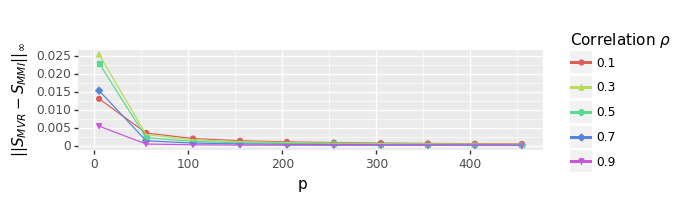

<ggplot: (8749872031450)>


In [10]:
g = (ggplot(df,
     aes(x='p', shape='factor(rho)', color='factor(rho)', y='value'))
        + geom_point()
        + geom_line()
        + labs(
            y=r'$||S_{MVR} - S_{MMI}||_{\infty}$',
            color=r'Correlation $\rho$',
            shape=r'Correlation $\rho$',
        )
        + theme(figure_size=(6,1.3))
)
print(g)

## Figure 15

In [11]:
p = 500
dgprocess = knockpy.dgp.DGP()
_,_,_,_,V = dgprocess.sample_data(method='ver', delta=0.01, p=p)
SMVR = knockpy.mrc.solve_mvr(V)
SCI = knockpy.mrc.solve_ciknock(V)

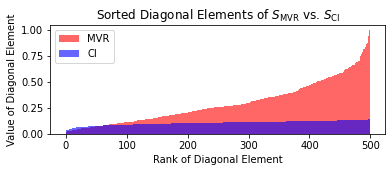

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 2))
x = np.arange(p)
plt.bar(
    x,
    np.sort(np.diag(SMVR)), 
    color='red', 
    alpha=0.6, 
    width=1.0, 
    label=r'MVR'
)
plt.bar(
    x,
    np.sort(np.diag(SCI)), 
    color='blue', 
    alpha=0.6, 
    width=1.0, 
    label=r'CI'
)
plt.legend()
plt.title(r"Sorted Diagonal Elements of $S_{\mathrm{MVR}}$ vs. $S_{\mathrm{CI}}$")
plt.xlabel(r"Rank of Diagonal Element")
plt.ylabel(r"Value of Diagonal Element")
plt.show()

### Testing ExactSDP

In [28]:
class ExactSDPEquiKnock(knockpy.knockoffs.GaussianSampler):
    """
    Samples SDP knockoffs exactly, with no
    tolerance added (so no numerical errors)
    for equicorrelated covariance matrices with
    rho >= 0.5.
    """

    def sample_knockoffs(self):
        """ 
        ensures GSDP is exactly rank p+1 with the right low-rank structure
        """

        super().sample_knockoffs()
        sumcols = self.X[:, 0] + self.Xk[:, 0]
        self.Xk = sumcols.reshape(-1, 1) - self.X


In [29]:
dgprocess = knockpy.dgp.DGP()
dgprocess.sample_data()
print()

In [30]:
esdp = ExactSDPEquiKnock(
    X=dgprocess.X,
)

In [31]:
esdp.sample_knockoffs()

[[-3.27960804 -3.27960804 -3.27960804 ... -3.27960804 -3.27960804
  -3.27960804]
 [-0.49265797 -0.49265797 -0.49265797 ... -0.49265797 -0.49265797
  -0.49265797]
 [ 2.91839265  2.91839265  2.91839265 ...  2.91839265  2.91839265
   2.91839265]
 ...
 [-3.48084239 -3.48084239 -3.48084239 ... -3.48084239 -3.48084239
  -3.48084239]
 [-0.37057564 -0.37057564 -0.37057564 ... -0.37057564 -0.37057564
  -0.37057564]
 [-1.78824014 -1.78824014 -1.78824014 ... -1.78824014 -1.78824014
  -1.78824014]]
